In [1]:
import numpy as np
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.svm import SVC
#from sklearn.model_selection import KFold

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import time
import progressbar

from smo import *
from mySVM_class import *


import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('Data/train.csv', nrows = 2000)

In [3]:
images = ["%s%s" %("pixel",pixel_no) for pixel_no in range(0,28**2)]
train_images = np.array(train[images], dtype=np.float)/100
train_labels = np.array(train['label'])
label_even = np.array([1 if i%2==0 else -1 for i in train_labels]) #All even numbers get the label 1, the odd ones get -1

## Linear Kernel
In order to find out which C yields the qualitatively best classifiert, we determine for several values of C a score ($score=\frac{\#correct}{\#all}$).
For each of these values, we separate the data randomly into trainings data and test data multiple times, and cross-validate each time using this partition. Afterwards, we average over these multiple scores and compare the outcome for the different values of C.

In [32]:
%%time

no_samples = 1000
scores_list = []
no_itereations = 1

C_list = [2., 5., 6., 7.]
with progressbar.ProgressBar(max_value=len(C_list)*no_itereations) as bar:
    bar.update(0)
    for i in range(no_itereations):
        scores_list.append([])
        for C in C_list:
            scores_list[i].append(cross_validation(train_images[:no_samples],label_even[:no_samples], C, scalar_product))
            bar.update(C_list.index(C)*(i+1))
print(scores_list)

100% (4 of 4) |###########################| Elapsed Time: 0:08:35 Time: 0:08:35


[[0.81299999999999994, 0.81800000000000006, 0.83699999999999997, 0.83199999999999996]]
CPU times: user 33min 11s, sys: 22.9 s, total: 33min 34s
Wall time: 8min 35s


In [34]:
S = np.mean(scores_list, axis = 0)
S

array([ 0.813,  0.818,  0.837,  0.832])

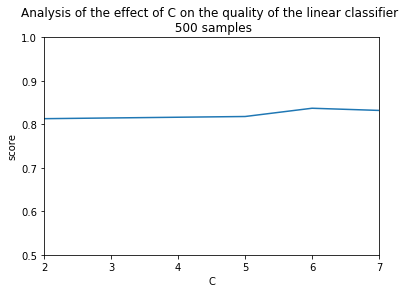

In [35]:
figure_parameterC = plt.figure();
plt.plot(C_list, S);
#plt.xscale('log');
plt.ylim([0.5,1]);
plt.xlim([2,7]);

plt.title('Analysis of the effect of C on the quality of the linear classifier \n 500 samples');
plt.xlabel('C');
plt.ylabel('score');
plt.savefig('CAnalysis_linear.pdf')

Observation: C has no noticeable effect on the quality of a linear classifier.

## Crossvalidating ECOC with Linear Kernel

In [ ]:
%%time

no_samples = 1500
penalty = 6.
score = cross_validation_ecoc(train_images[:no_samples], train_labels[:no_samples], penalty)
print(score)

## Gaussian Kernel

In [48]:
%%time
C_list = [20., 25., 30., 35.]
sigma_list = [0.0005,0.00075, 0.001, 0.0025]
no_samples = 200
scores_list = []
for i in range(3):
    scores_list.append([])
    for C in C_list:
        templist = []
        for sigma in sigma_list:
            templist.append(cross_validation(train_images[:no_samples],label_even[:no_samples], C, gaussian_kernel, sigma=sigma))
        scores_list[i].append(templist)
#print(scores_list)

20.0 0.0005 [  5.39045666e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.73707901e+00   3.73978100e+00   5.88682596e+00   0.00000000e+00
   0.00000000e+00   5.00871672e+00   0.00000000e+00   1.85626579e+00
   7.10458066e+00   0.00000000e+00   2.47869894e+00   1.42594061e+01
   8.60709087e+00   9.53342765e-02   4.69918716e+00   9.56593590e-01
   1.77851041e+00  -1.11022302e-16   0.00000000e+00   2.29498667e+00
   6.01527672e+00   2.02191049e+00   3.54445176e+00   0.00000000e+00
   0.00000000e+00   6.56322933e+00   0.00000000e+00   0.00000000e+00
   9.43342560e-03   0.00000000e+00   4.66016194e+00   3.67384247e+00
   5.13019320e+00   0.00000000e+00   5.78668400e+00   0.00000000e+00
   1.30633935e+01   5.42674736e-01   9.00028658e-01   1.93516023e+00
   7.59662971e-01   8.62183189e+00   0.00000000e+00   1.21695361e+01
   4.26453531e-01   0.00000000e+00   0.00000000e+00   7.13495661e+00
   7.12759515e+00   2.86795758e+00   1.07342272e+01   0.00000000e+00
   4.42795900e+00   0.

In [49]:
mean_scores = np.mean(scores_list, axis = 0)
np.shape(mean_scores)

(4, 4)

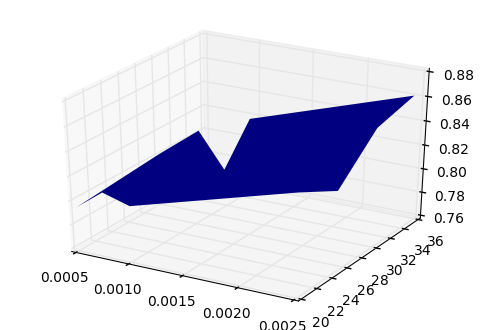

In [50]:
sigma, C = np.meshgrid(np.array(sigma_list), np.array(C_list))
Z = np.array(mean_scores)
Z = np.reshape(Z, np.shape(C))
figure_ParameterCsigma = plt.figure()
ax = figure_ParameterCsigma.gca(projection='3d')
surf = ax.plot_surface(sigma, C, Z,
                       linewidth=0, antialiased=False)
#figure_ParameterCsigma.colorbar(surf, shrink = 0.5, aspect=5)
#plt.xscale('log')

In [51]:
Z

array([[ 0.795     ,  0.81166667,  0.805     ,  0.84333333],
       [ 0.79833333,  0.78833333,  0.82833333,  0.825     ],
       [ 0.80166667,  0.79166667,  0.79833333,  0.85666667],
       [ 0.80333333,  0.77333333,  0.82166667,  0.865     ]])

In [36]:
C

array([[ 18.,  18.,  18.,  18.,  18.],
       [ 20.,  20.,  20.,  20.,  20.],
       [ 25.,  25.,  25.,  25.,  25.],
       [ 30.,  30.,  30.,  30.,  30.],
       [ 34.,  34.,  34.,  34.,  34.],
       [ 36.,  36.,  36.,  36.,  36.],
       [ 38.,  38.,  38.,  38.,  38.]])

# access through: scores_list[i][j][k] = score of: i'th round (i as above), j'th C in C_list, k'th sigma in sigma_list


# access: S[j][k] = mean score over all three trials for j'th C in C_list and for k'th sigma in sigma_list